<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Graphs in Machine Learning</h1>
<h1>RGNs, K-Nearest Neighbours and DBSCAN</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider

import tqdm as tq
from tqdm import tqdm

import networkx as nx
import scipy
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform

import sklearn
from sklearn import datasets
from sklearn.cluster import DBSCAN

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: e7579285e4e2577e47f35dad1660e09e4abc3917

watermark : 2.1.0
sklearn   : 0.23.2
numpy     : 1.19.2
json      : 2.0.9
ipywidgets: 7.5.1
tqdm      : 4.50.2
pandas    : 1.1.3
networkx  : 2.5
scipy     : 1.5.2
matplotlib: 3.3.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Random Geometric Graphs

In [4]:
N=100

In [5]:
coords = np.random.random((N, 2))

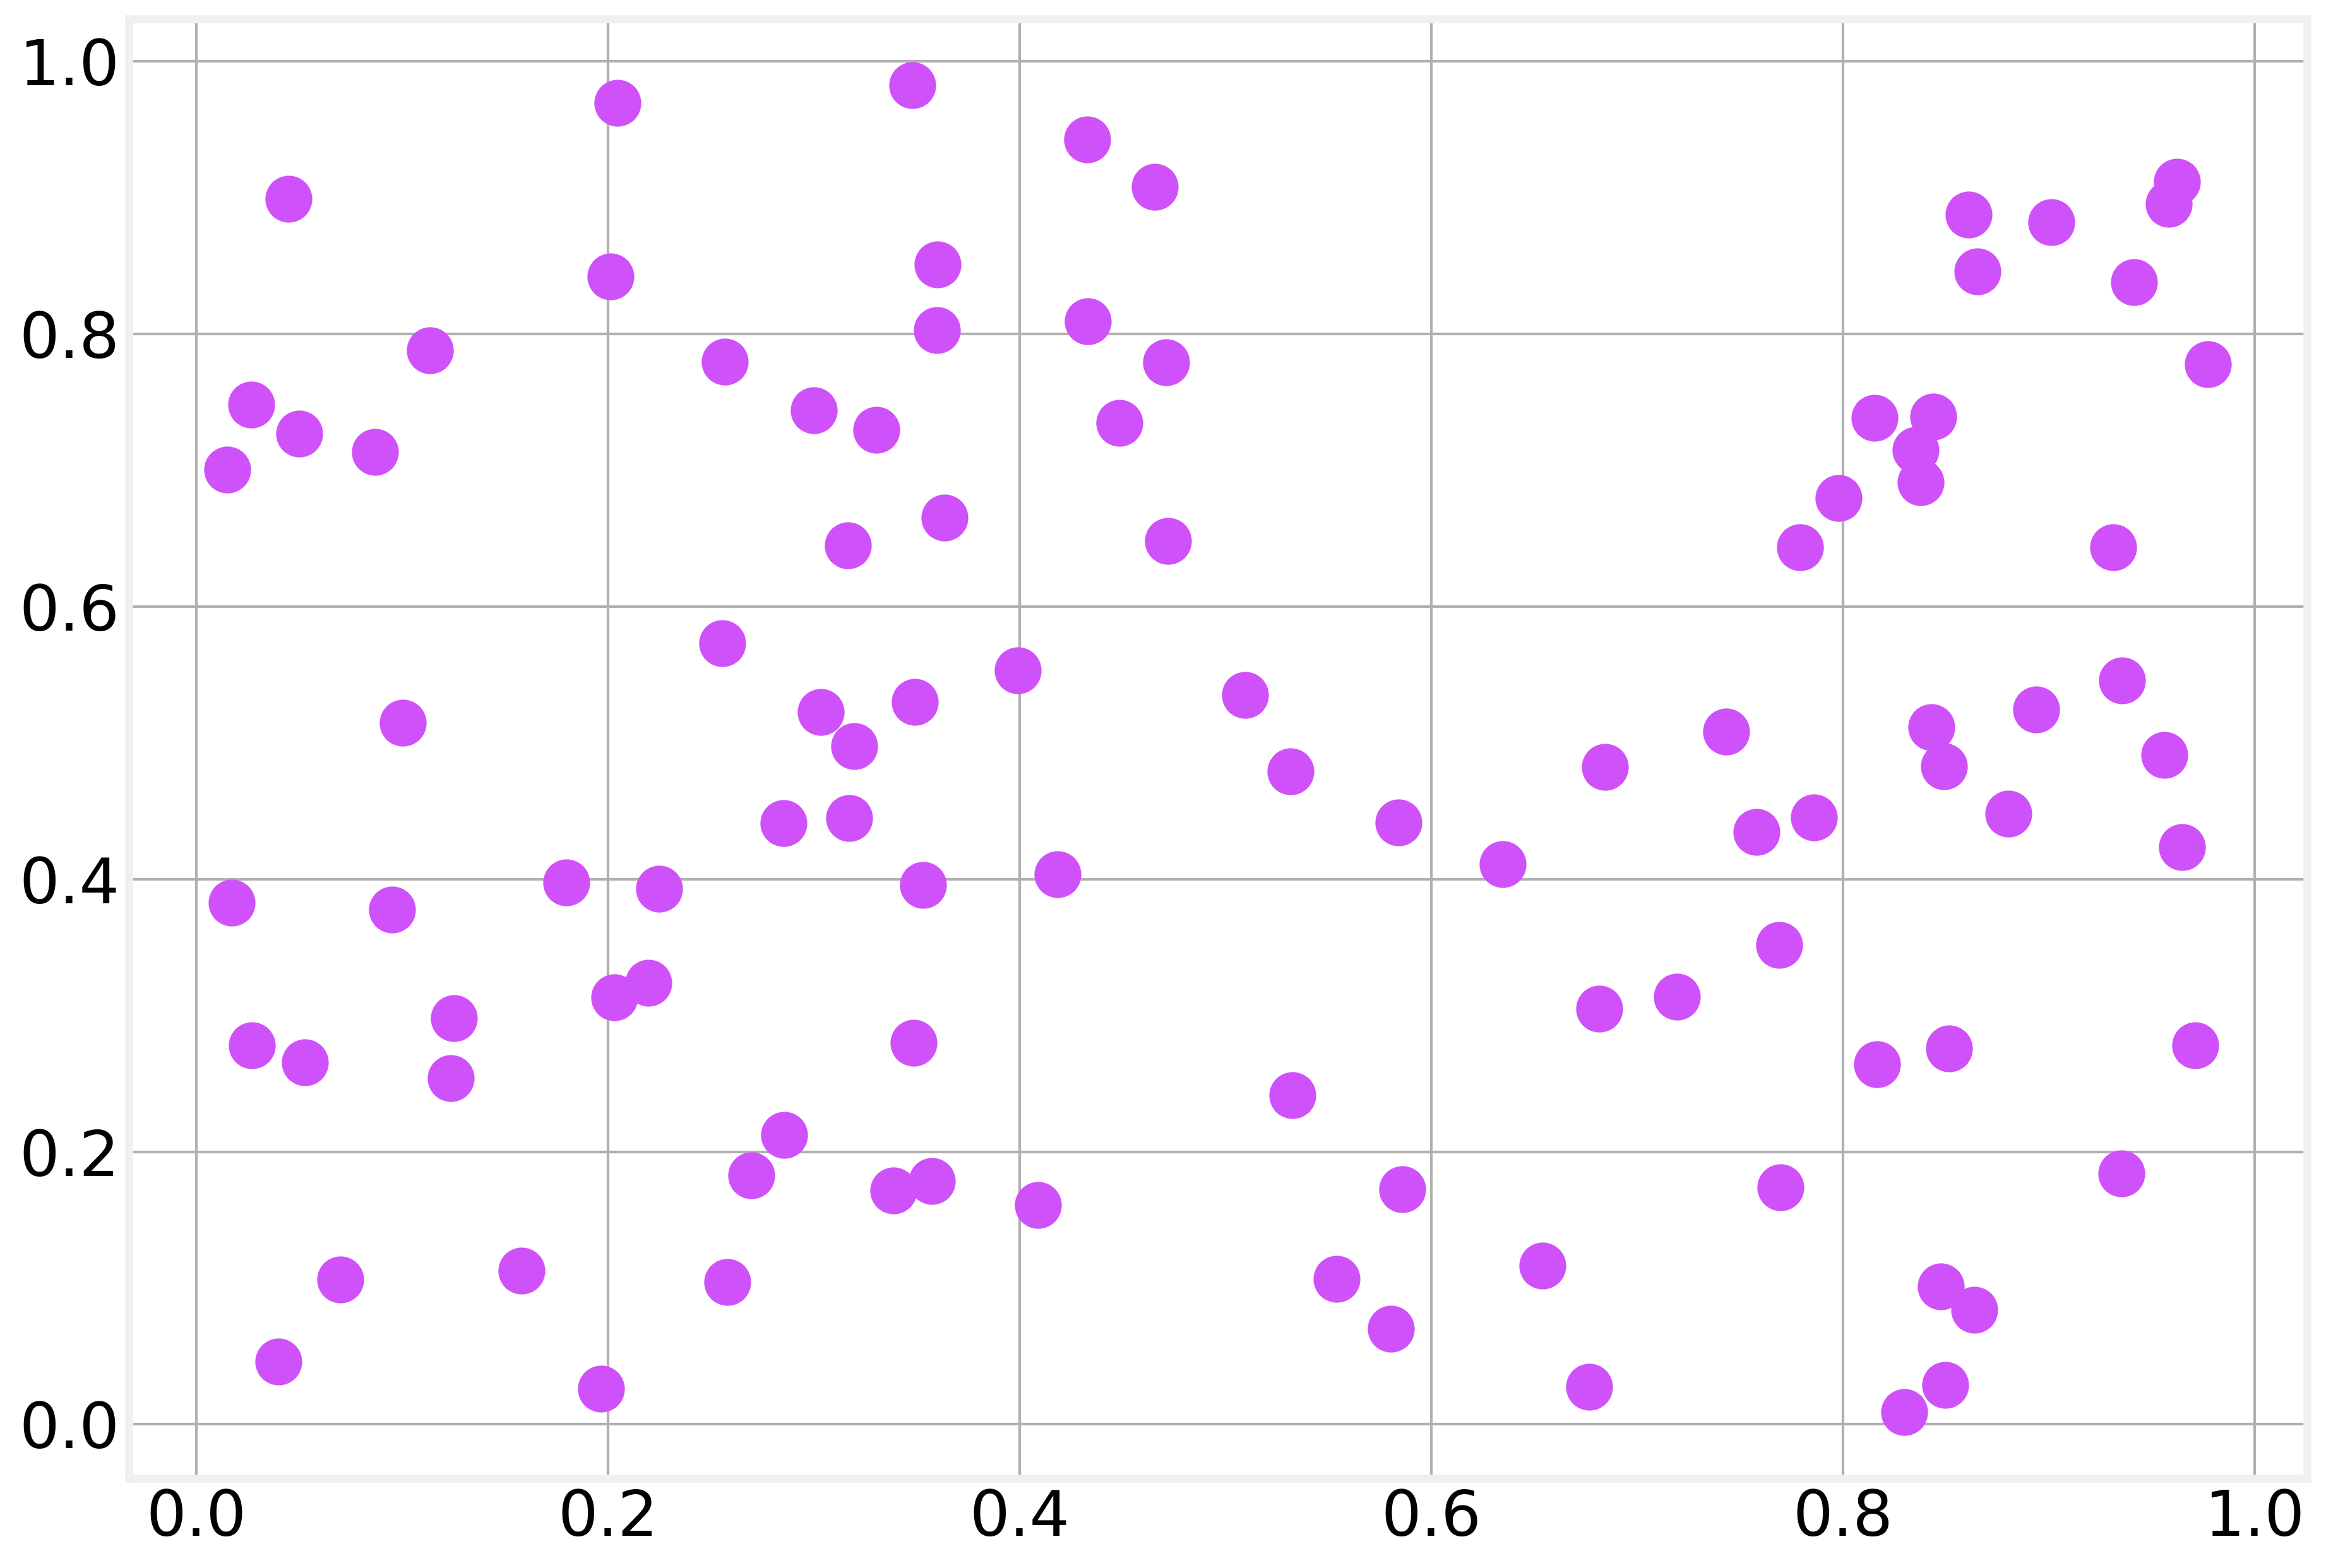

In [6]:
plt.scatter(x=coords[:, 0], y=coords[:, 1], color=colors[1], s=300)

In [7]:
matrix = distance_matrix(coords, coords, 2)

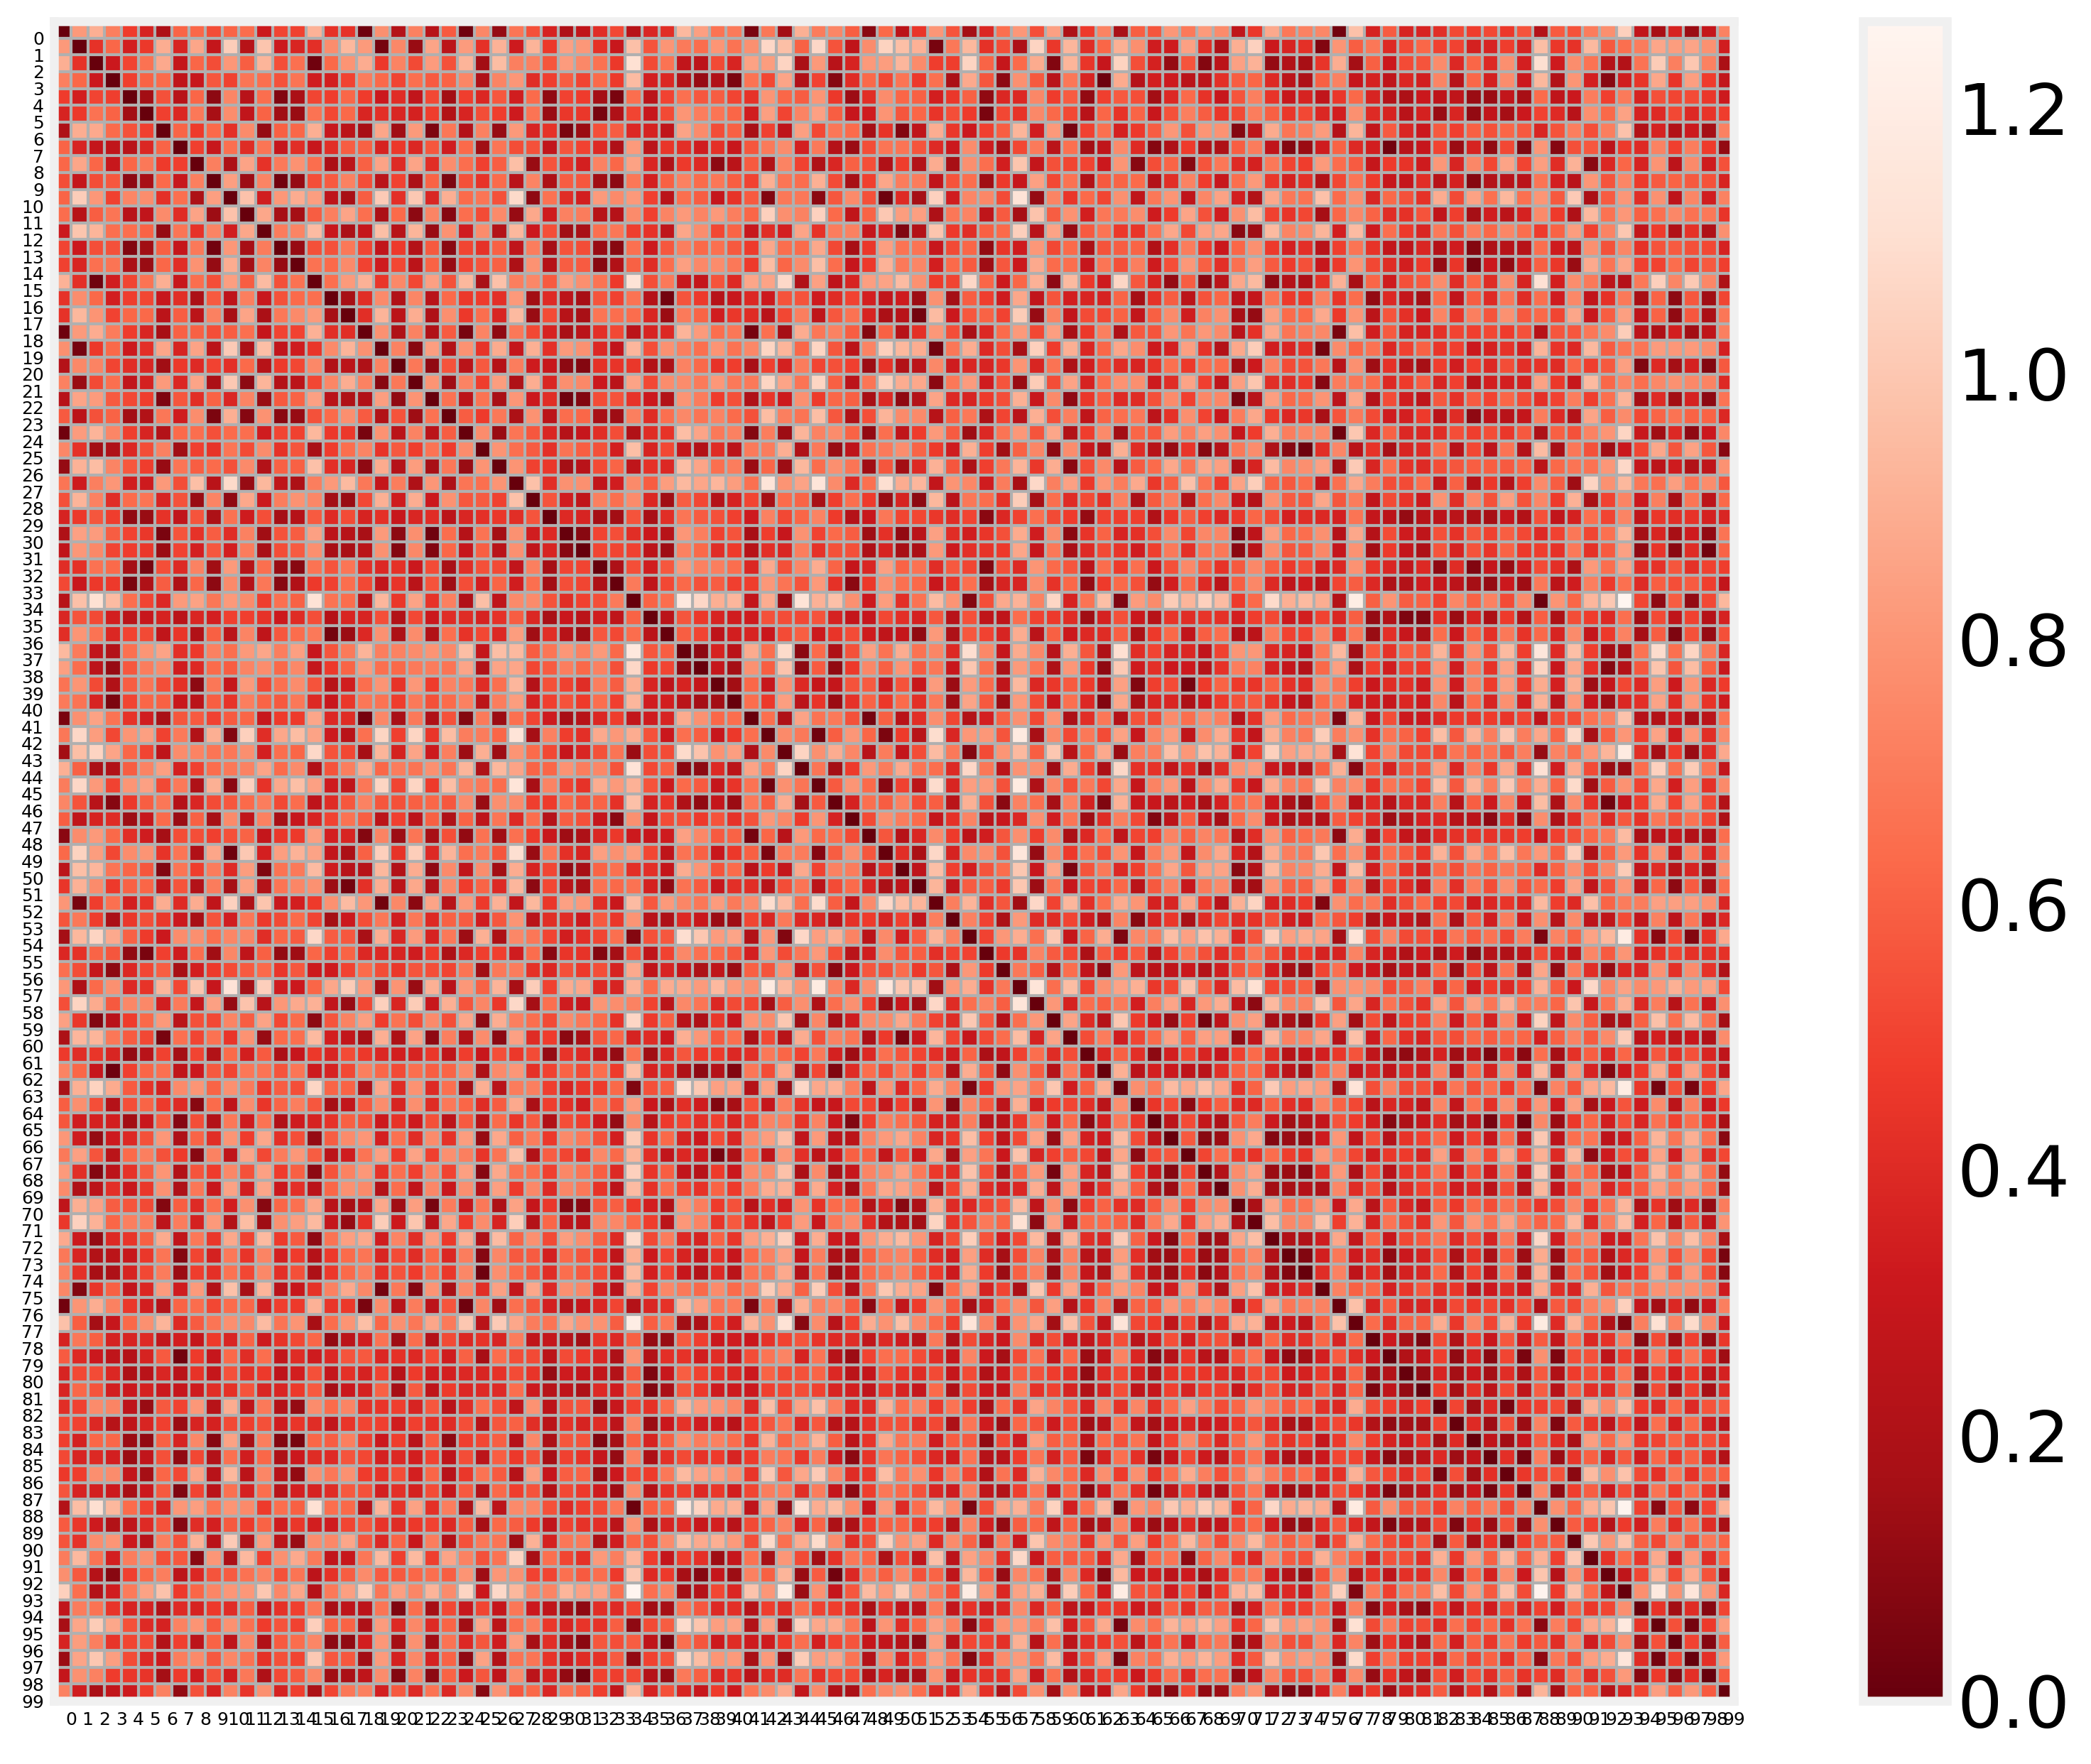

In [8]:
plt.imshow(matrix, cmap=plt.cm.Reds_r)
plt.yticks(np.arange(0.5, N, 1), np.arange(N), fontsize=6)
plt.xticks(np.arange(0.5, N, 1), np.arange(N), fontsize=6)
plt.colorbar();

In [9]:
hist = pd.DataFrame(list(Counter(np.round(matrix[matrix>0].flatten()*100)/100).items()), columns=['d', 'P(d)'])

In [10]:
hist.sort_values('d', inplace=True)
hist['P(d)']/=hist['P(d)'].sum()

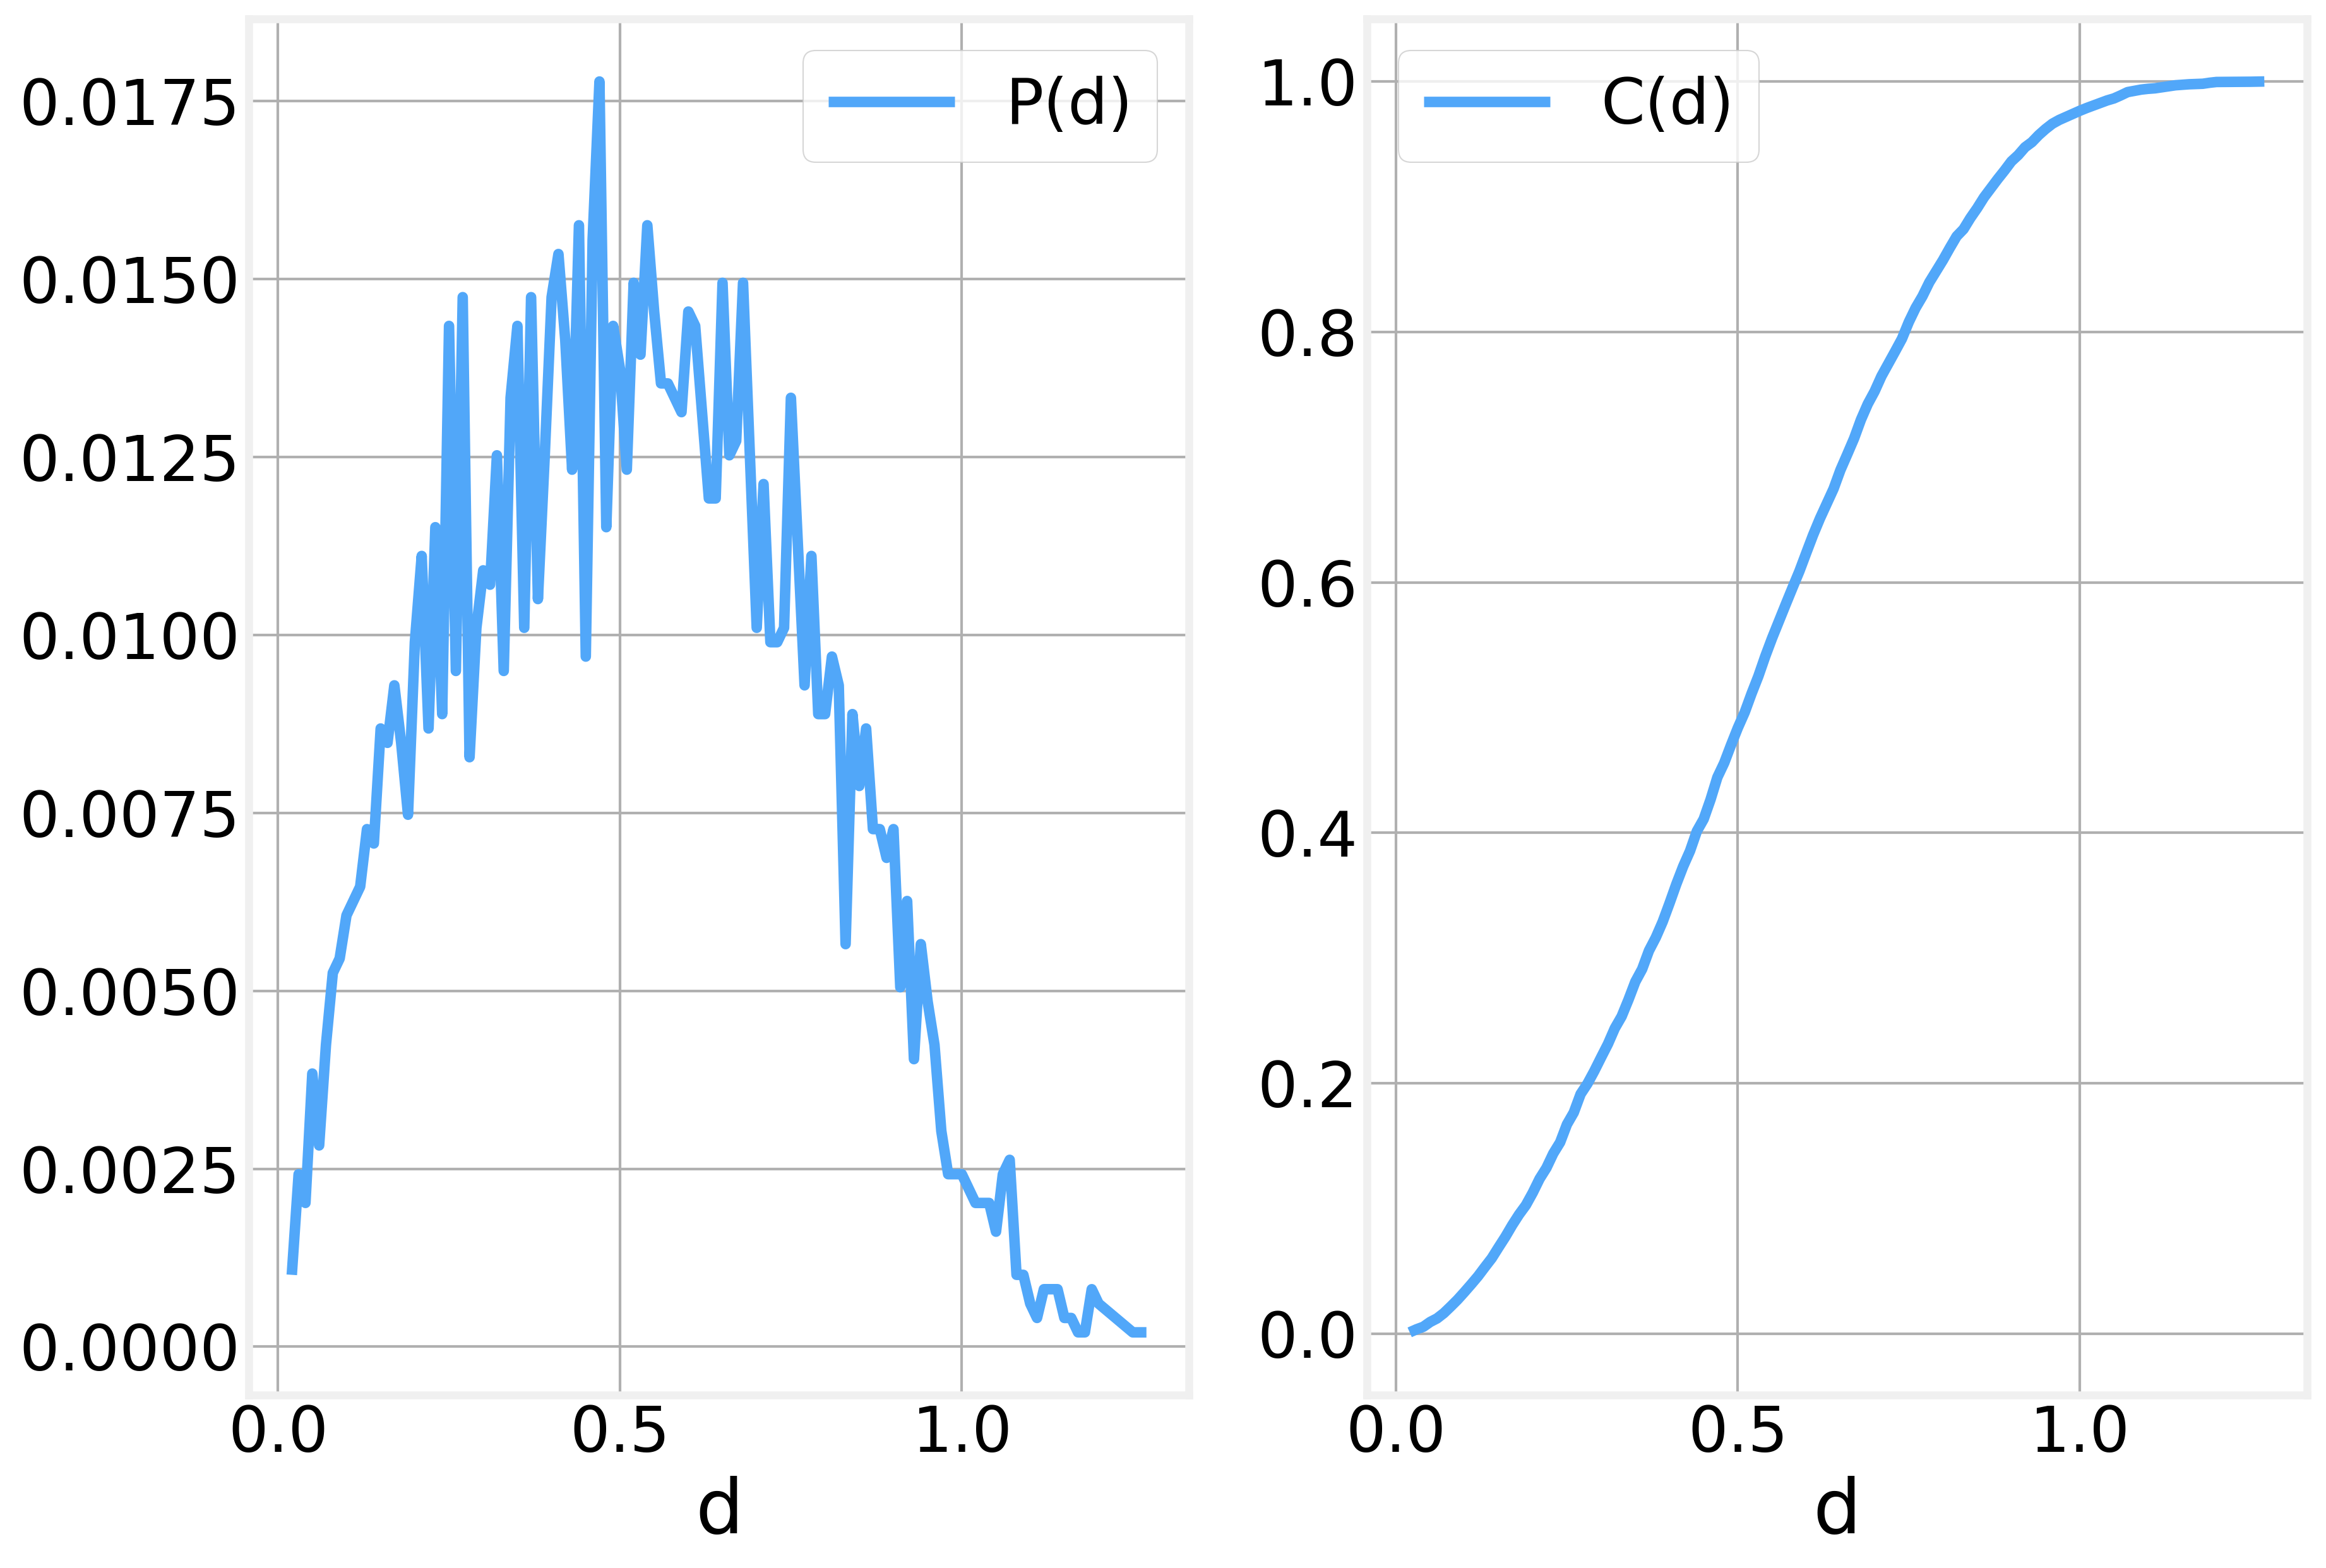

In [11]:
fig, (ax, ax2) = plt.subplots(1, 2)
hist.plot(x='d', y='P(d)', ax=ax)
cumul = hist.copy()
cumul['P(d)'] = hist['P(d)'].cumsum()
cumul.plot(x='d', y='P(d)', ax=ax2)
ax2.legend(['C(d)'])

In [12]:
@interact
def plot_selection(Threshold = widgets.FloatSlider(min=0.1, max=1.2, step=0.1, value=.1, readout=True)):
    selection = matrix.copy()
    selection[selection>Threshold] = 0
    
    edges = sorted([[i, j, matrix[i, j]] 
                    for i, j in np.asarray(np.nonzero(selection)).T], key=lambda x:x[2])
    edges_array = np.asarray(edges)
    
    G = nx.Graph()
    G.add_nodes_from(np.arange(N))
    G.add_edges_from(edges_array[:, :2].astype('int').tolist())
    
    print("Number of conneced components:", len(list(nx.connected_components(G))))

    selection = matrix.copy()
    selection[selection>Threshold] = np.nan
    
    fig, (ax, ax2) = plt.subplots(1, 2)
    ax.imshow(selection, cmap=plt.cm.Reds_r, vmin=0, vmax=1.2)
    
    nx.draw_networkx_edges(G, pos=coords,
                           edge_color=plt.cm.Reds_r(edges_array.T[2].T), 
                           alpha=1, ax=ax2)
    ax2.scatter(coords[:, 0], coords[:, 1], color=colors[1], s=100)
    
    
    ax2.set_aspect(1.)

interactive(children=(FloatSlider(value=0.1, description='Threshold', max=1.2, min=0.1), Output()), _dom_class…

# K-Nearest Neighbors

In [13]:
def knn(coords, k=2):
    matrix = squareform(pdist(coords))
    
    NN = np.argpartition(matrix, k+1, axis=1)[:, :k+1]
    
    return NN

In [14]:
def get_edges(coords, k=3):
    NN = knn(coords, k)
    
    edges = []
    
    for i in range(len(NN)):
        edges.extend([(i, NN[i, j]) for j in range(k+1) if NN[i, j] != i])

    return edges

In [15]:
NN = knn(coords, 2)

In [16]:
edges = get_edges(coords, 5)

In [17]:
G = nx.DiGraph()
G.add_nodes_from(np.arange(N))
G.add_edges_from(edges)

In [18]:
degrees = G.in_degree()

In [19]:
sort_degrees = np.asarray(G.in_degree(), dtype='float')
sort_degrees.T[1] -= (sort_degrees.T[1].min()-1)
sort_degrees.T[1] = sort_degrees.T[1] / sort_degrees.T[1].max()

/Users/bgoncalves/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


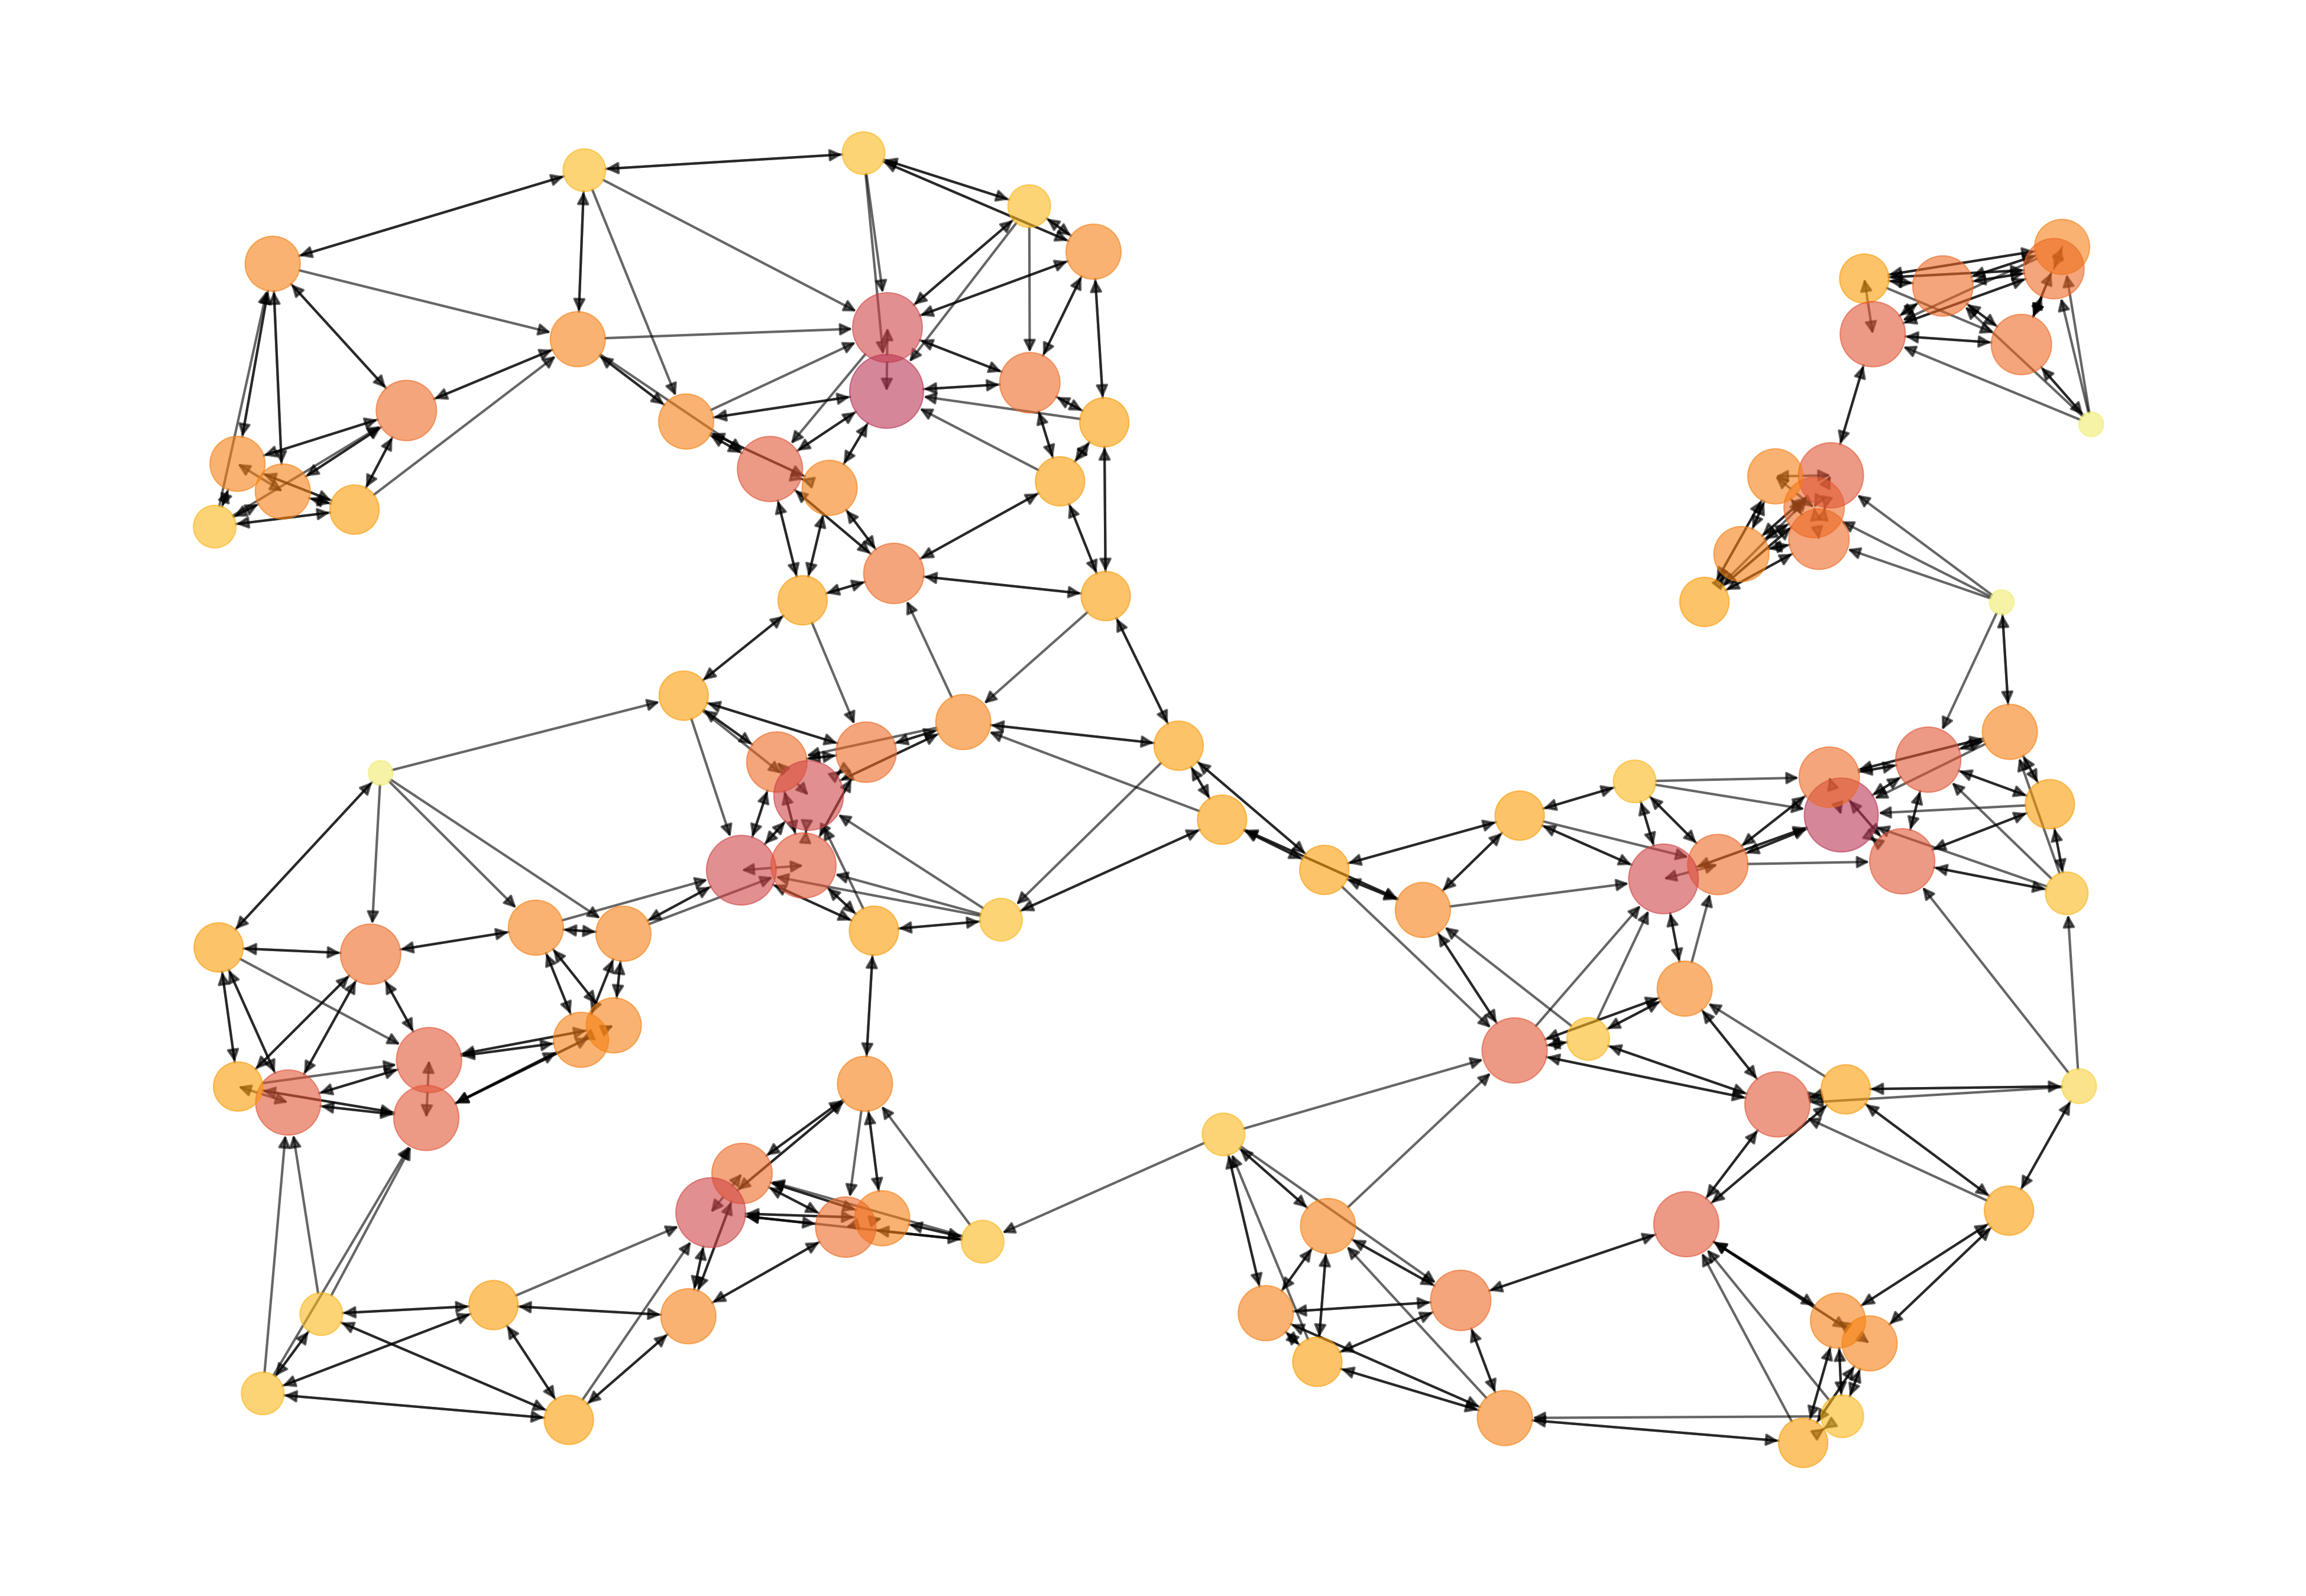

In [20]:
nx.draw(G, pos=coords, node_color=plt.cm.inferno_r(sort_degrees.T[1]/2), 
        node_size=900*(sort_degrees.T[1]), alpha=0.6)

# DBSCAN

In [21]:
X, y = datasets.make_moons(n_samples=300, noise=0.08, shuffle=False)

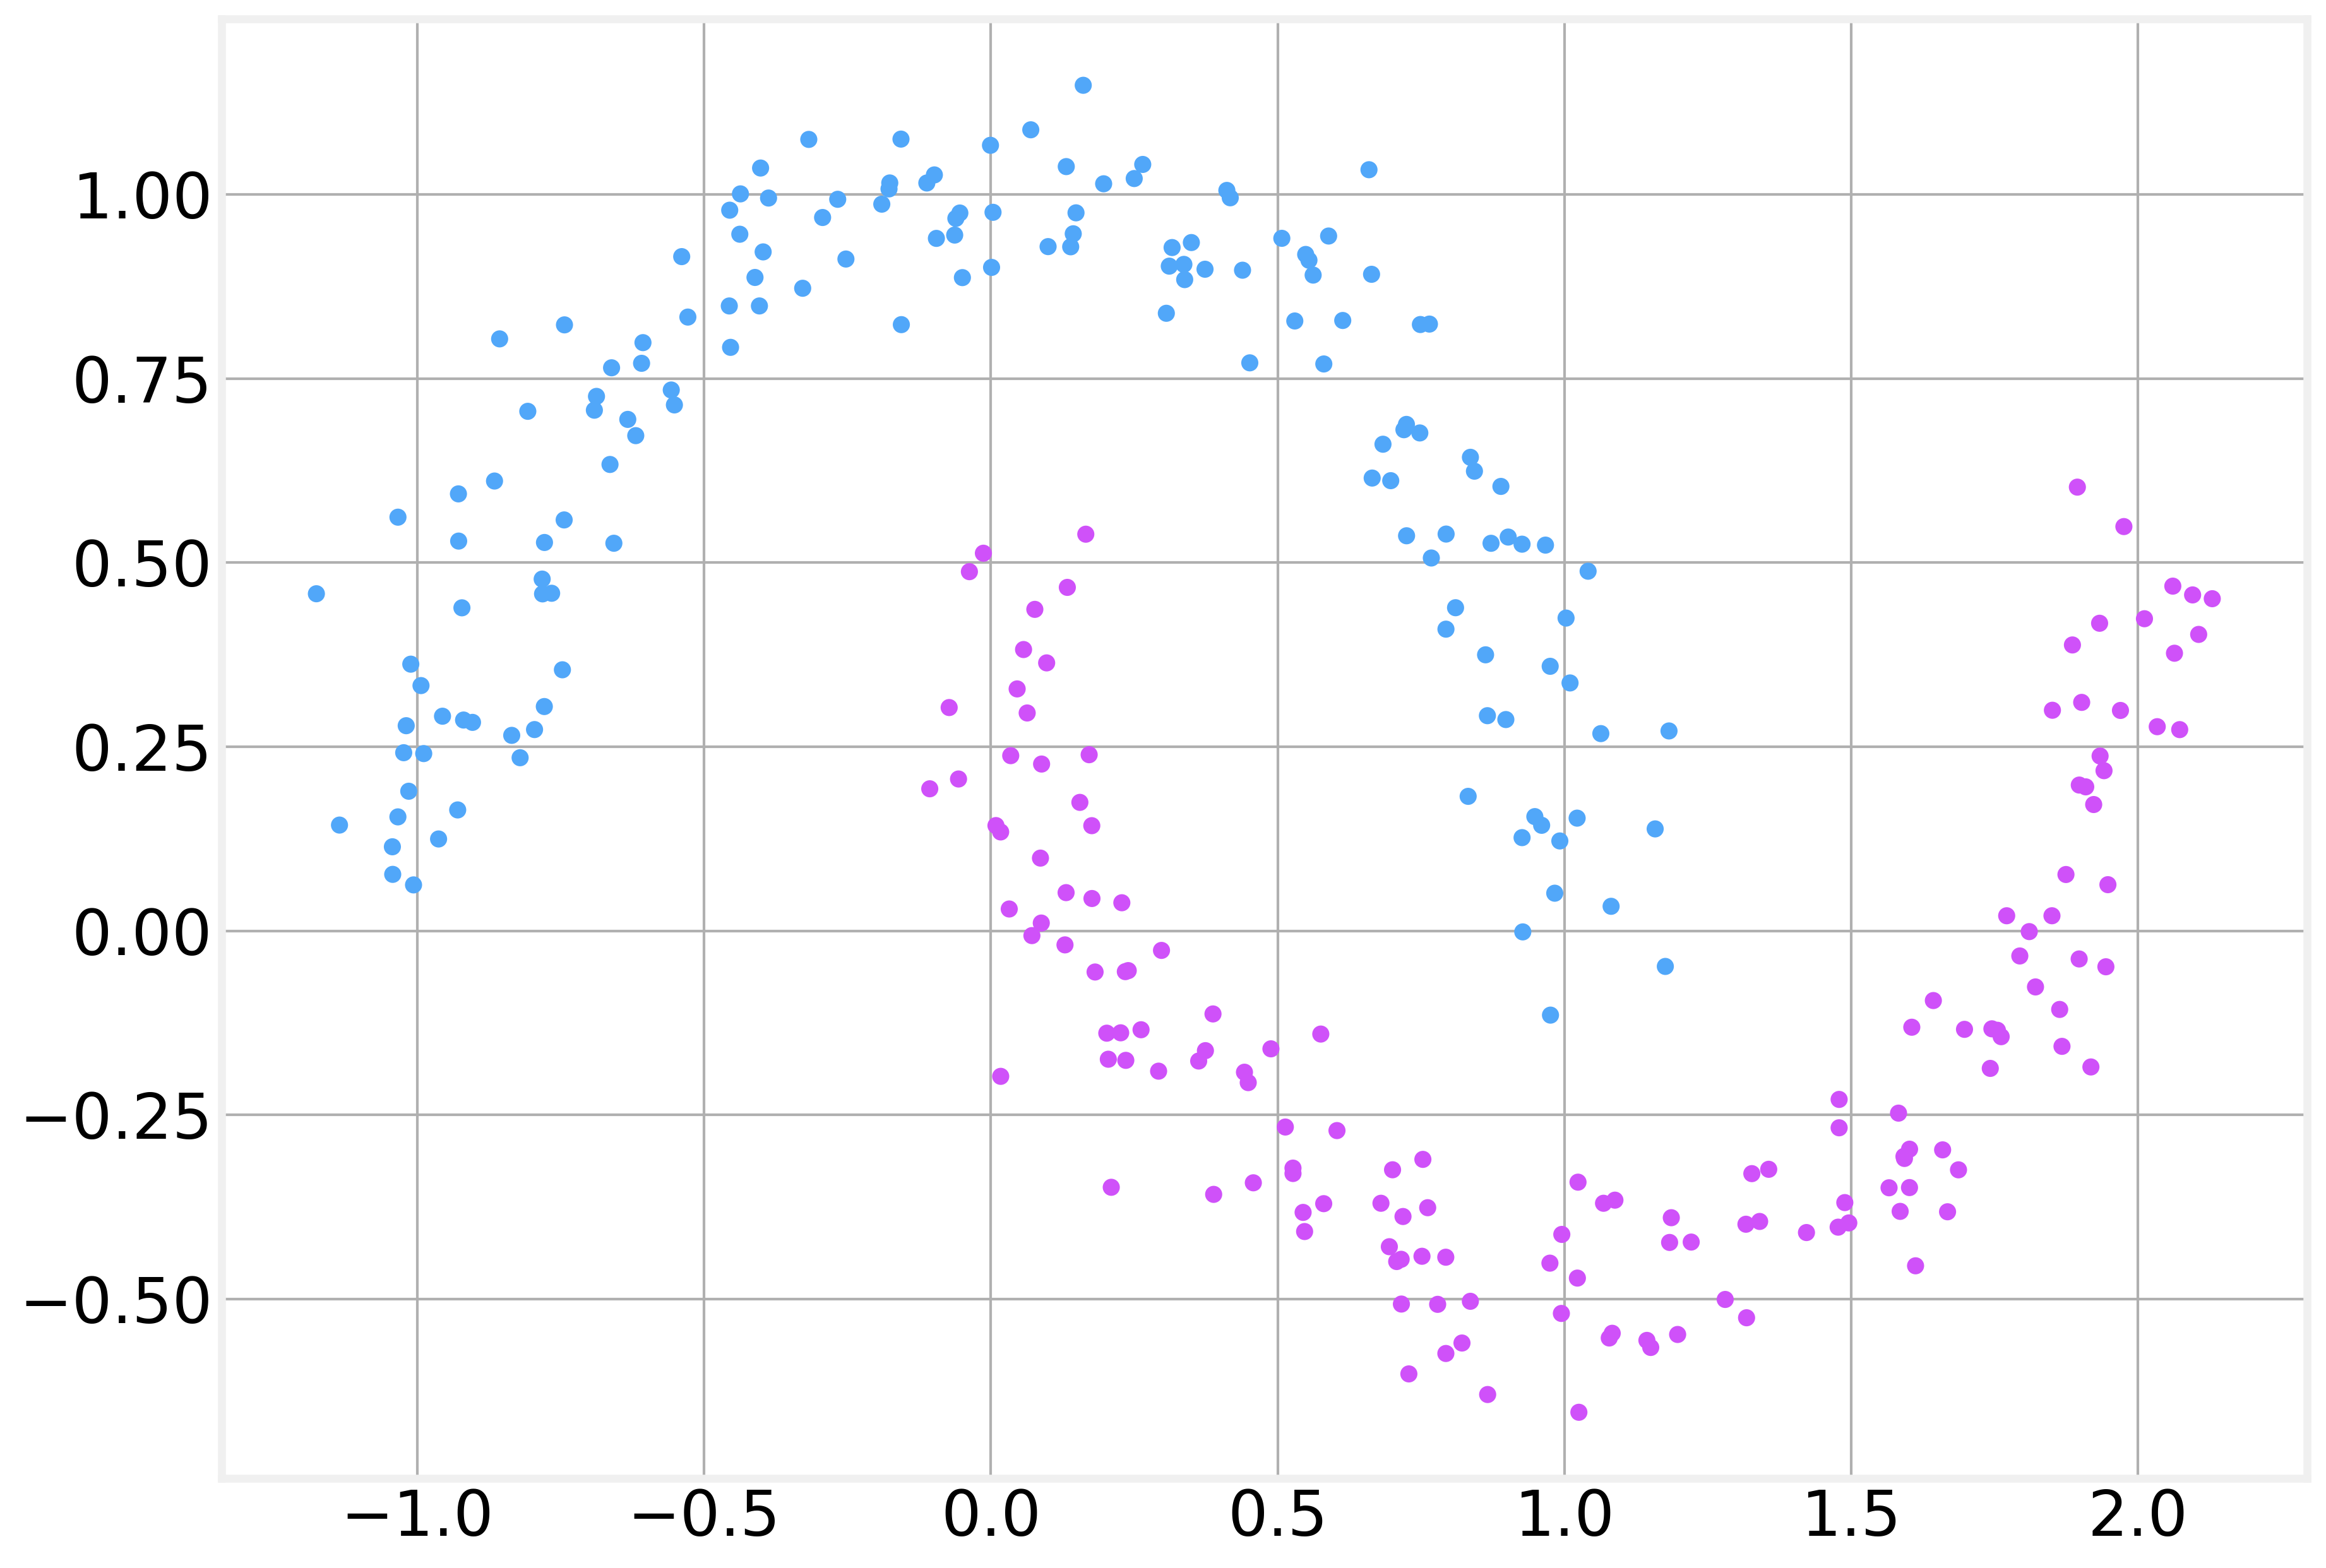

In [22]:
plt.scatter(X.T[0], X.T[1], color=np.array(colors)[y])

In [23]:
def net_DBSCAN(X, eps=0.17, min_samples=5):
    matrix = squareform(pdist(X))
    matrix[matrix >= eps] = 0
    
    G = nx.DiGraph()
    G.add_edges_from(np.asarray(np.nonzero(matrix)).T)
    G2 = G.to_undirected()
    
    results = {}
    results['core_sample_indices_'] = [node_i 
                                       for node_i, k in G2.degree() 
                                           if k >= min_samples-1]
    
    labels = []
    for label, comp in enumerate(nx.connected_components(G2)):
        for node in comp:
            labels.append(label)
            
    results['labels_'] = np.asarray(labels)
    results['G'] = G
    
    results['non_core'] = set(np.arange(X.shape[0])) - set(results['core_sample_indices_'])
    
    return results

In [24]:
results = net_DBSCAN(X, eps=0.17, min_samples=5)

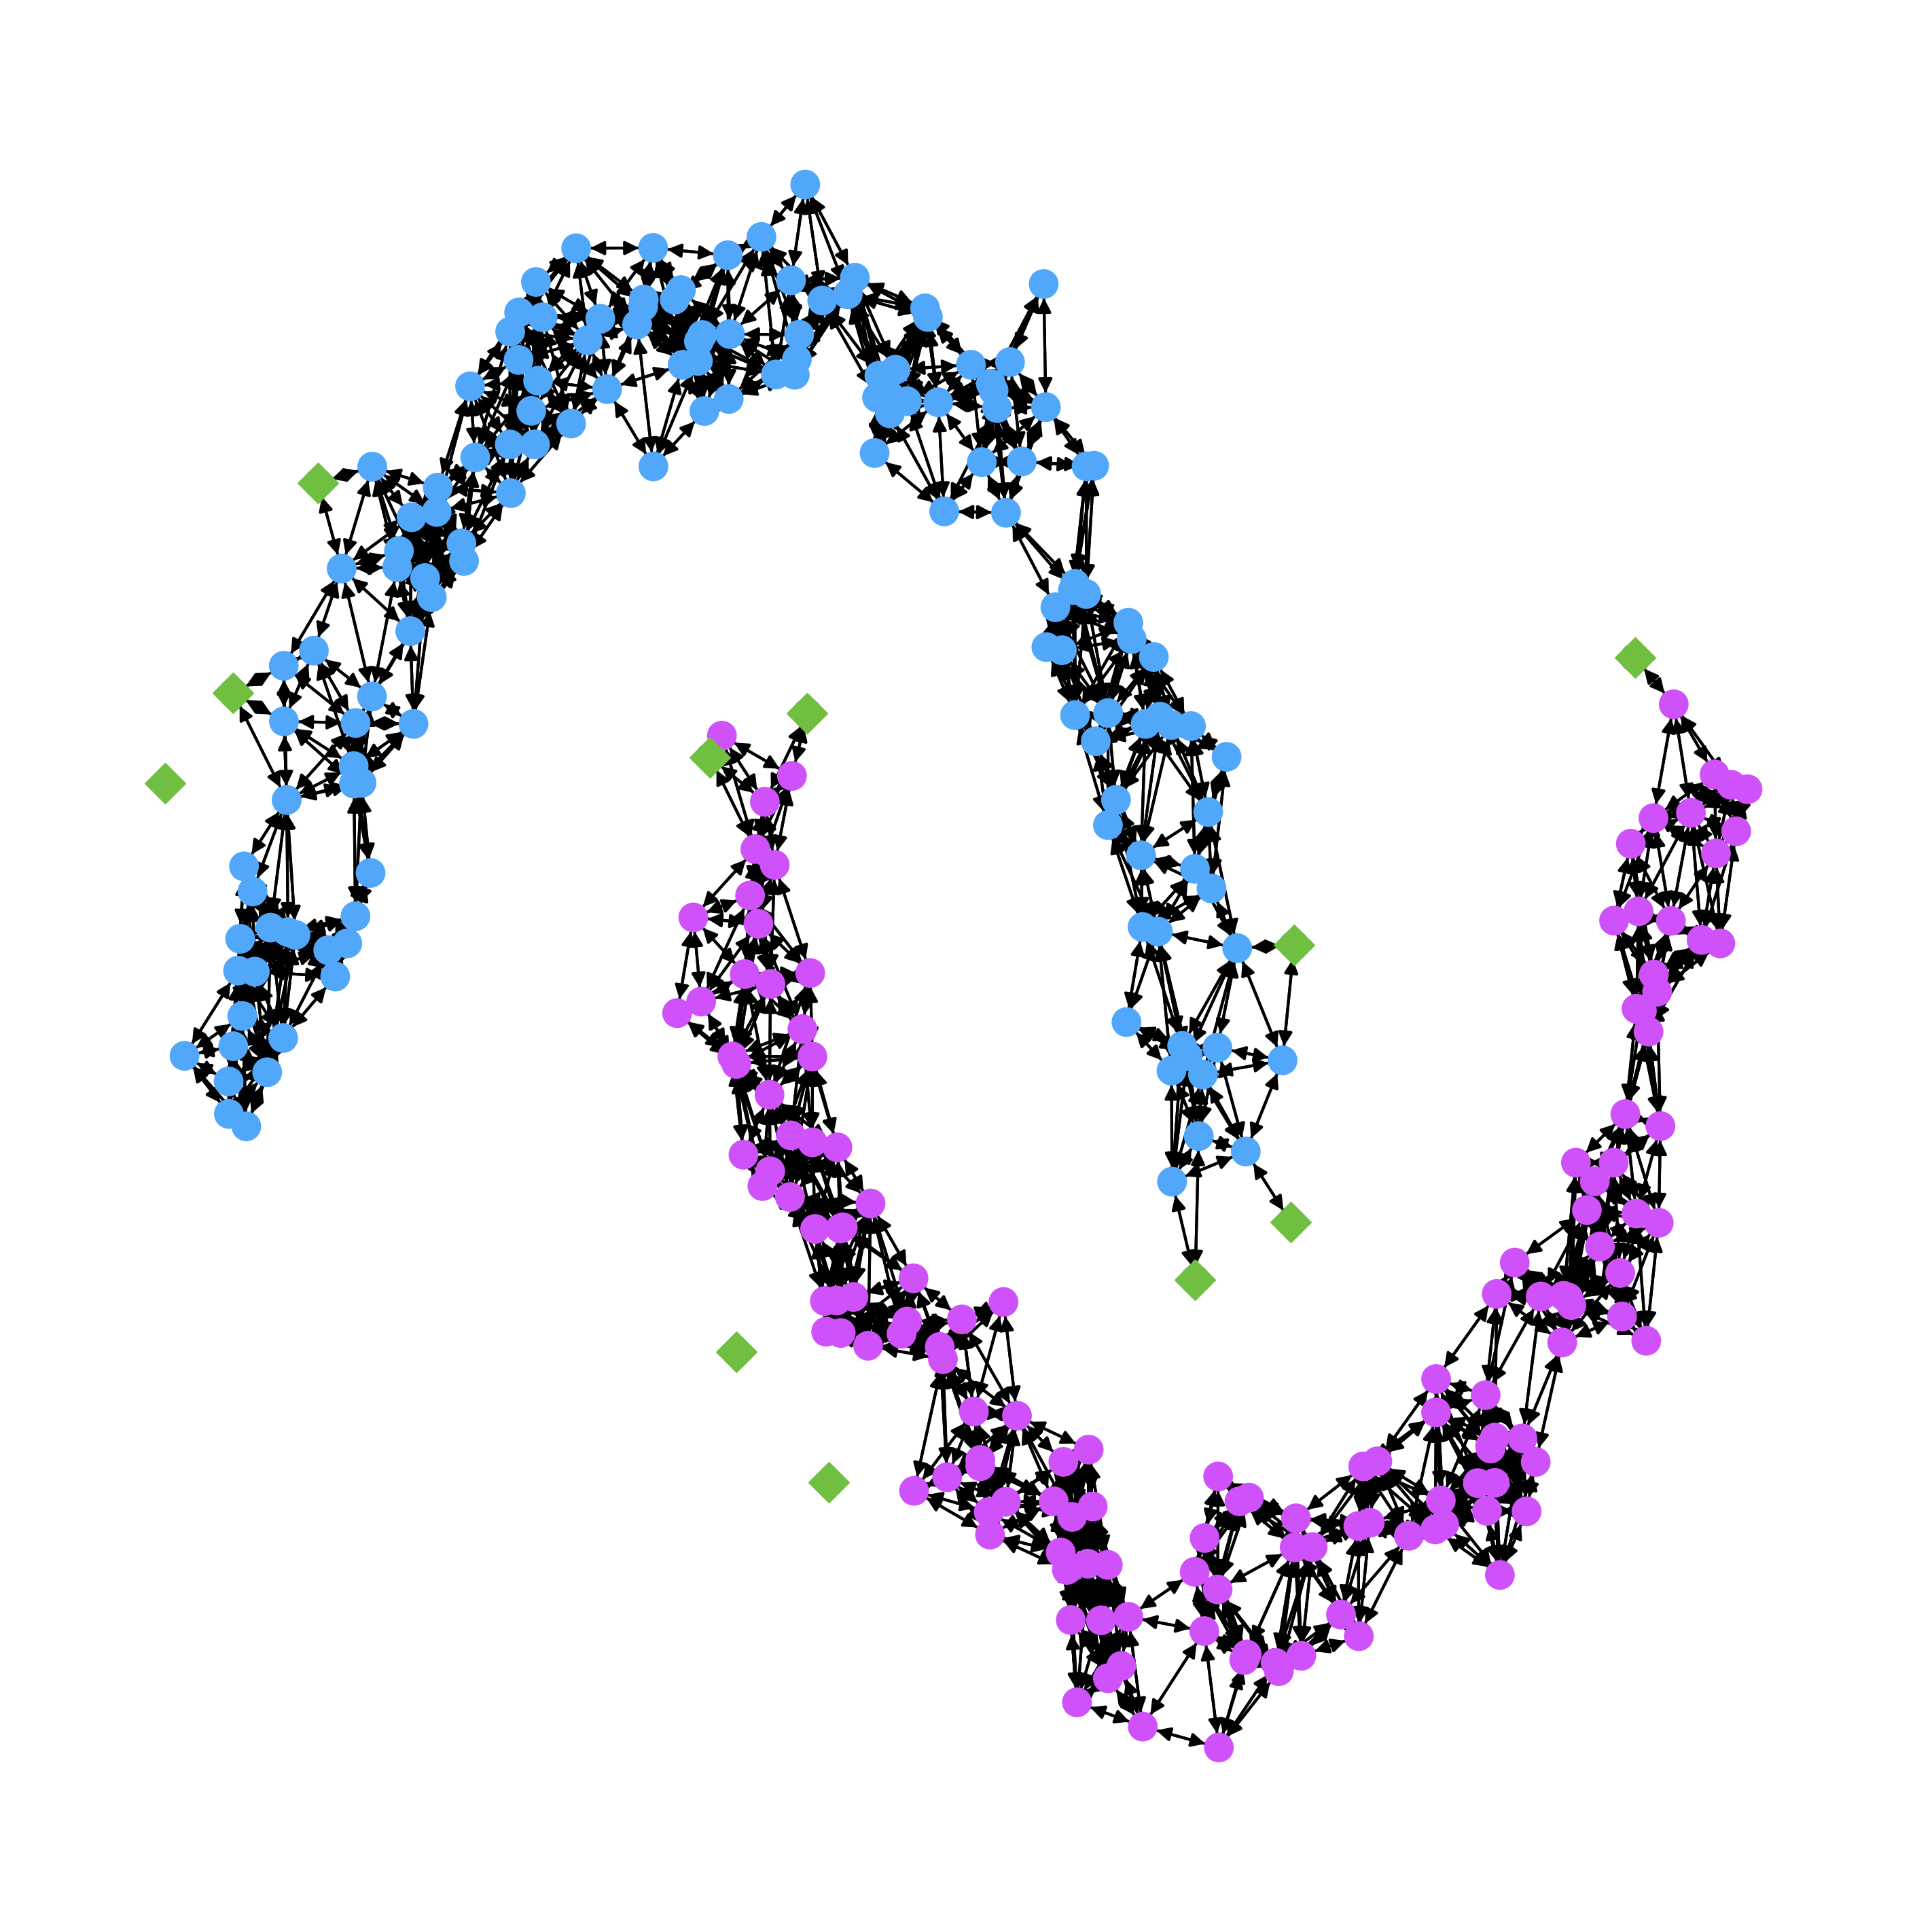

In [25]:
fig, ax = plt.subplots(1, figsize=(10,10))

nx.draw(results['G'], pos=X, 
        ax=ax, 
        node_size=100, 
        node_color=np.asarray(colors)[results['labels_']])

nx.draw_networkx_nodes(results['G'], pos=X,
                       ax=ax,
                       node_size=100, 
                       nodelist=results['non_core'], 
                       node_color=colors[2],
                       node_shape='D')

Now we compare our results with the ones obtained by sklearn on the same dataset

In [26]:
db = DBSCAN(eps=0.17, min_samples=5).fit(X)

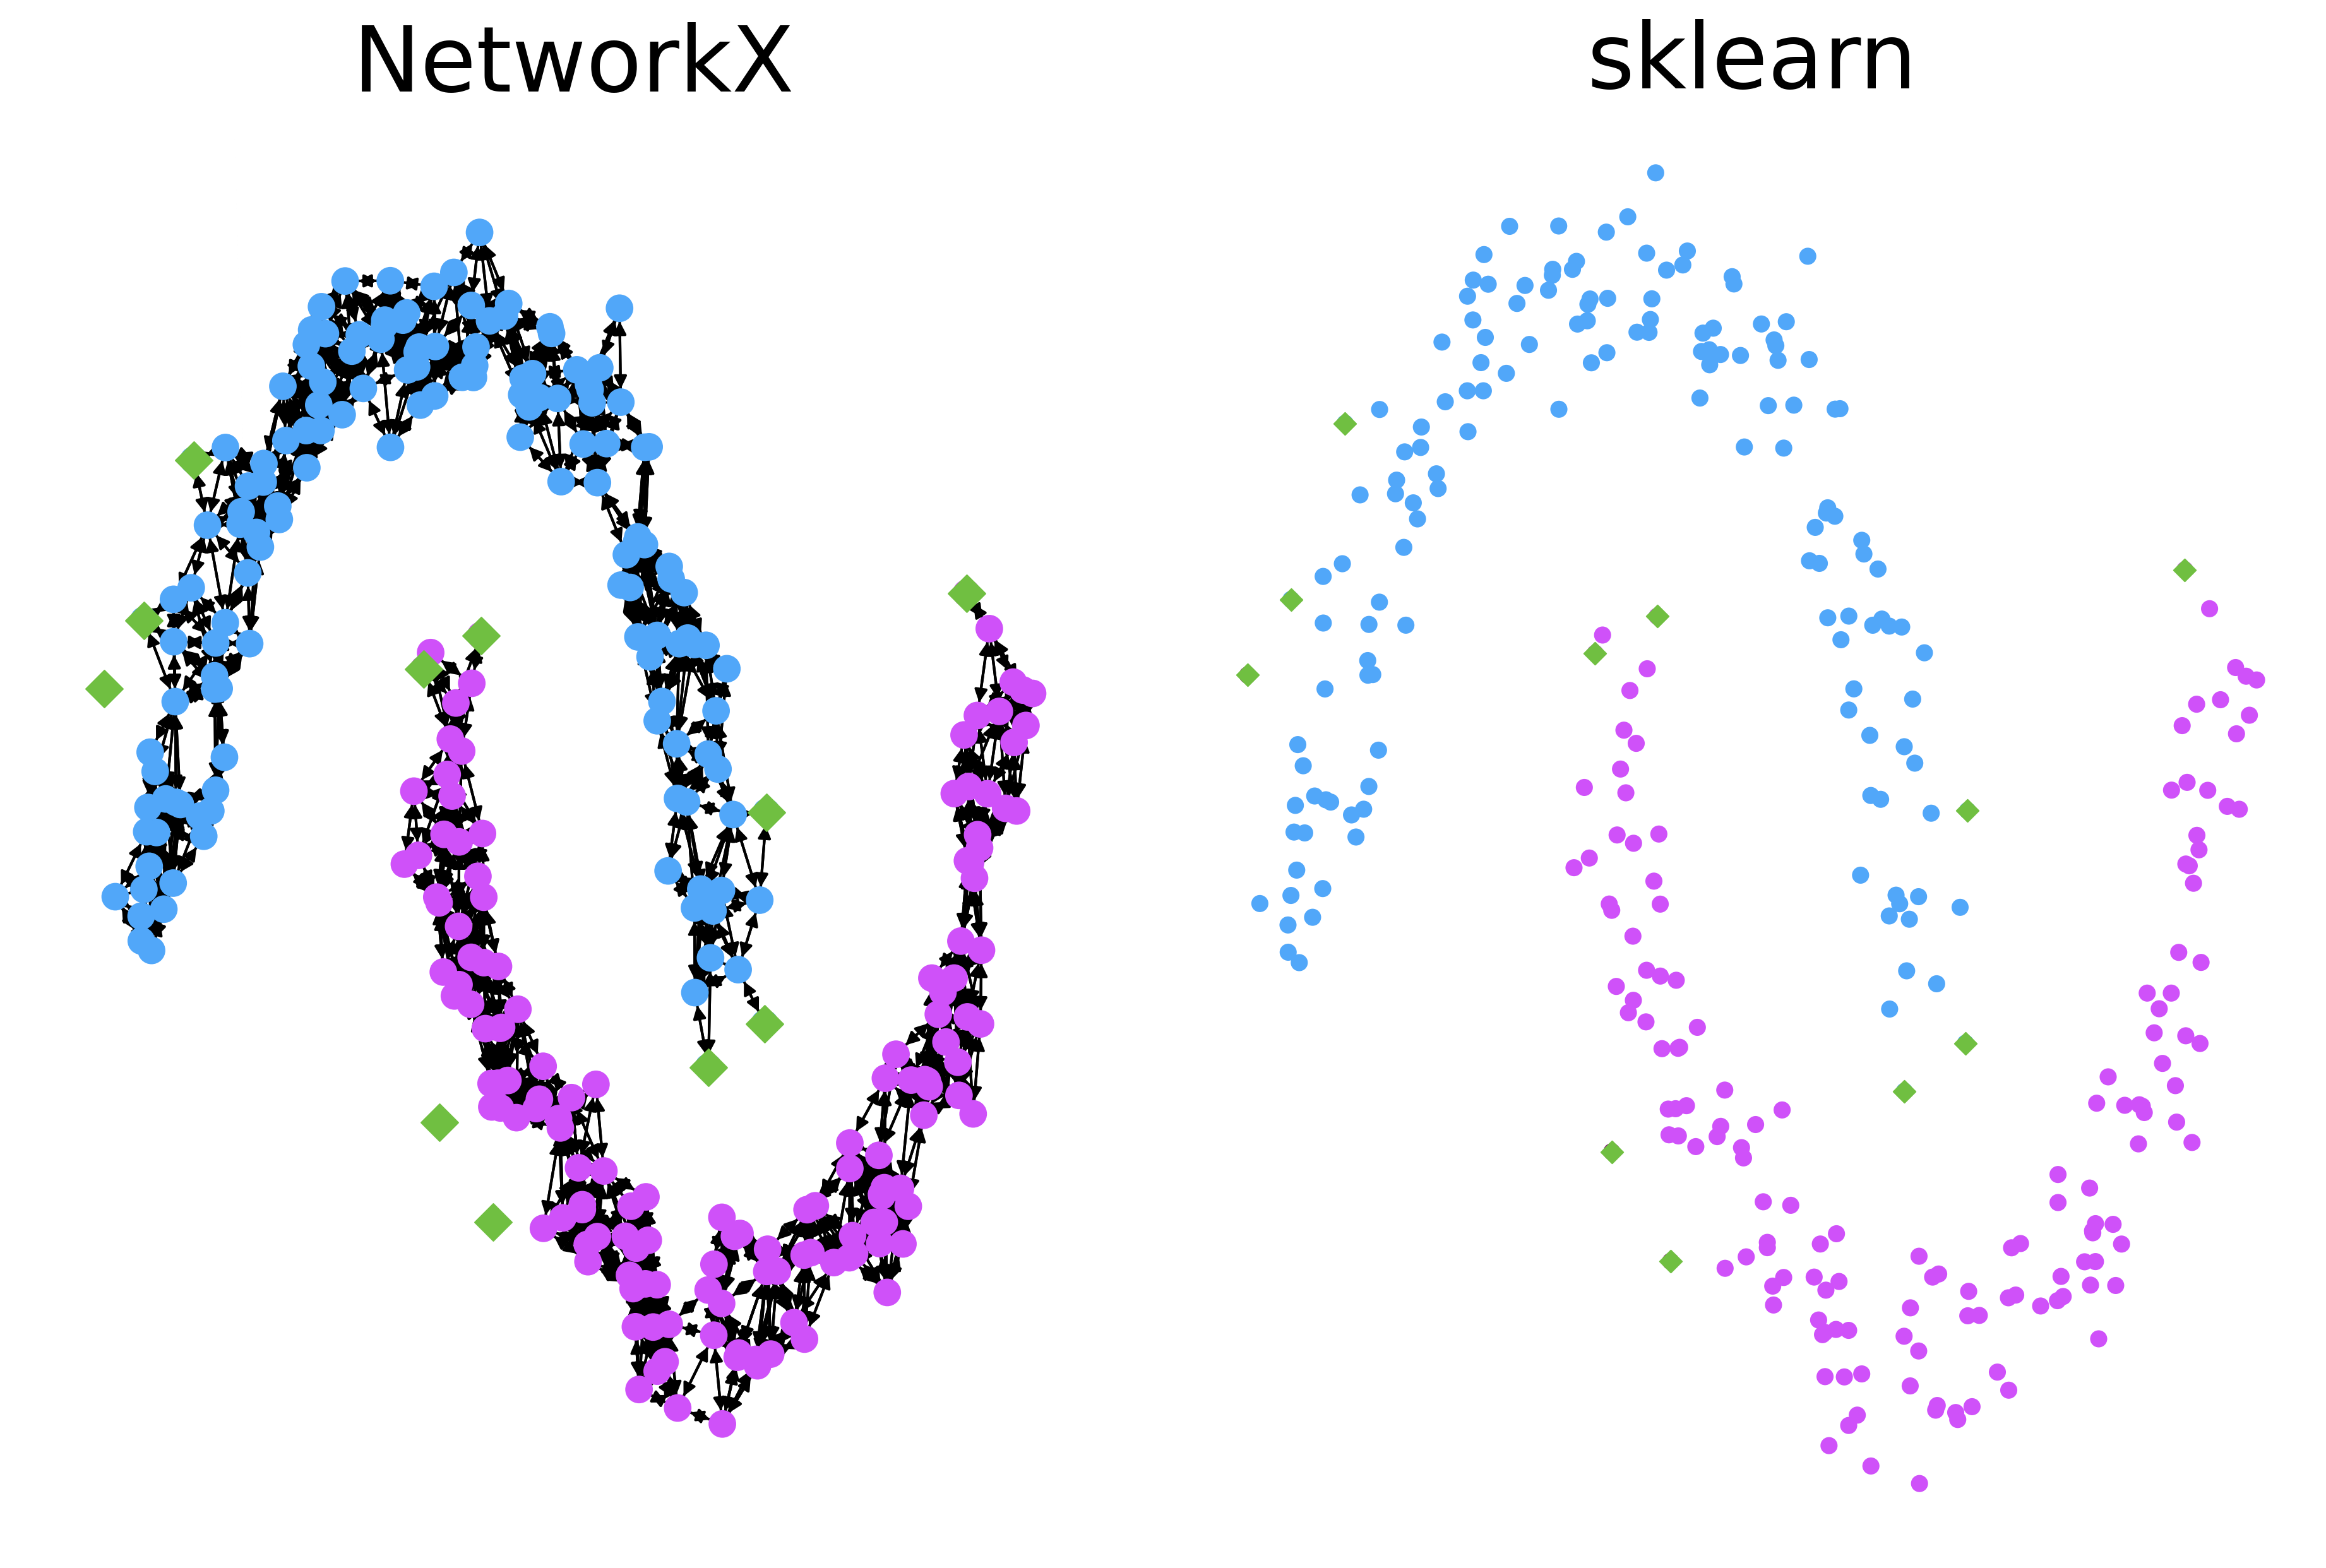

In [27]:
fig, (ax, ax2) = plt.subplots(1, 2)

nx.draw(results['G'], pos=X, 
        ax=ax, 
        node_size=100, 
        node_color=np.asarray(colors)[results['labels_']])

nx.draw_networkx_nodes(results['G'], pos=X,
                       ax=ax,
                       node_size=100, 
                       nodelist=results['non_core'], 
                       node_color=colors[2],
                       node_shape='D')

ax.set_title('NetworkX')

non_core = np.asarray(list(set(np.arange(X.shape[0])) - set(db.core_sample_indices_)))

ax2.scatter(X.T[0], X.T[1], color=np.asarray(colors)[db.labels_])
ax2.scatter(X.T[0][non_core], X.T[1][non_core], marker='D', color=colors[2])

ax2.set_title('sklearn')
ax2.axis('off')
fig.tight_layout();

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>